In this notebook, I will attempt to incorporate a single function which will train a model for a desired set of inputs and an output. This means the function can be called twice on seperate occasions to find predicitons for sersic index and half radius within seperate architectures. This will hopefully reduce confusion within the bnn as previously it was trying to find links between, f, n, and r when they are seperate variables.

We will start by creating a function which, initialises, pulls the training data, trains the model, and then tests it all in one. 

In [193]:
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [194]:
def BNN(dropout_prob, input_train, output_train, epochs, lr, input_test, output_test):
    #bnn model architecture 
    model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=1000),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=113),
    )
    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model = model.train()

    #training model

    for _ in range(epochs): 
        pred = model(input_train)

        mse = mse_loss(torch.unsqueeze(torch.Tensor(pred), dim = 1), torch.unsqueeze(torch.Tensor(output_train), dim=1))
        

        kl = kl_loss(model)
        cost = mse + kl_weight * kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
   
    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model = model.eval().cpu()
    input_test = input_test.cpu()
    output_test = output_test.cpu()

    pred = np.array([model(input_test).detach().numpy() for _ in range(500)]).T


    #for each prediction of row, find mean and standard deviation
    mean_results = np.mean(pred, axis = 2)
    std_results = np.std(pred, axis = 2)

    print(mean_results.shape)
    print(output_test.shape)

    #find the cost of the model
    mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_results), dim = 1), torch.unsqueeze(torch.Tensor(output_test.T), dim=1))

    kl = kl_loss(model)
    cost = mse + kl_weight * kl

    print(f"- Test Cost: {cost.item():.3f}")

    return mean_results, std_results


In [195]:
def read_params(filename: str, filepath: str = '../../data/radiative_transfer/input/'):
    """
    Read the parameters from the input file.

    Parameters:
    - filename (str): Name of the input file.
    - filepath (str): Path to the input file. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - table (dict): Dictionary containing the parameters.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):

        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )

        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table


In [196]:
def read_h5_file(filename: str, data, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../data/radiative_transfer/output/'):
    """
    Read the output file.

    Parameters:
    - filename (str): Name of the output file.
    - data (pd.DataFrame): DataFrame containing the data.
    - thetas (list): List of viewing angles.
    - log_mstar (float): log of stellar mass.
    - log_mdust_over_mstar (float): log of dust mass over stellar mass.
    - filepath (str): Path to the output file. Default is '../../data/radiative_transfer/output/'.

    Returns:
    - wvl (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    normalise = lambda x: (x - np.mean(x)) / np.std(x)

    filepath += filename 
    print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    for i in range(len(hdf_keys)):

        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy(dtype=np.float64) # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy(dtype=np.float64) # flux [W/m^2]
        r = table['r'].to_numpy(dtype=np.float64) # half-light radius [kpc]
        n = table['n'].to_numpy(dtype=np.float64) # Sersic index

        flux, r, n = normalise(flux), normalise(r), normalise(n)

        data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)

    return wvl, data.reset_index(drop=True)


In [197]:
def read_parameter_files(filenames: list, filepath: str = "../../data/radiative_transfer/input/"):
    """
    Read the parameter files.

    Parameters:
    - filenames (list): List of filenames.
    - filepath (str): Path to the parameter files. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - list_log_mstar (np.array): Array of log of stellar mass.
    - list_log_mdust_over_mstar (np.array): Array of log of dust mass over stellar mass.
    - list_theta (np.array): Array of viewing angles.
    """

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar

    return list_log_mstar, list_log_mdust_over_mstar, list_theta


In [198]:
def generate_dataset(data, params, files):
    """
    Generate the dataset.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - params (list): List of parameter files.
    - files (list): List of output files.

    Returns:
    - wavelength (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(params)

    for i in range(len(files)):
        wavelength, data = read_h5_file(files[i], data, np.sin(list_theta), list_log_mstar[i], list_log_mdust_over_mstar[i])

    return wavelength, data


In [199]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [file for file in os.listdir("../../data/radiative_transfer/input/") if file.startswith("parameters")]
h5_files = [file for file in os.listdir("../../data/radiative_transfer/output/") if file.startswith("data")]

wavelength, h5_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_files, h5_files)


../../data/radiative_transfer/output/data1.h5


C:\Users\joshu\AppData\Local\Temp\ipykernel_6964\1726315495.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)


../../data/radiative_transfer/output/data2.h5


../../data/radiative_transfer/output/data3.h5
../../data/radiative_transfer/output/data4.h5
../../data/radiative_transfer/output/data5.h5
../../data/radiative_transfer/output/data6.h5


In [200]:
def convert_to_tensor(data):
    """
    Convert the DataFrame to a tensor.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.

    Returns:
    - data (tensor): Tensor containing the data.
    """

    data = data.applymap(np.array)
    stacked_input_arrays = np.stack(data.apply(lambda row: np.stack(row, axis=0), axis=1).to_numpy())
    data = torch.Tensor(stacked_input_arrays).to(device)

    return data


In [201]:
#split h5_data into training and testing sets
train, test = train_test_split(h5_data, test_size=0.2, random_state=42)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

#split training and testing sets into inputs and outputs
train_inputs, train_outputs = train[["log_mstar", "log_mdust_over_mstar", "theta"]], train[["n", "flux", "r"]]
test_inputs, test_outputs = test[["log_mstar", "log_mdust_over_mstar", "theta"]], test[["n", "flux", "r"]]

#convert training and testing data into numpy arrays
train_inputs, test_inputs = train_inputs.to_numpy(), test_inputs.to_numpy()
train_inputs, test_inputs = torch.Tensor(train_inputs).to(device), torch.Tensor(test_inputs).to(device)

train_outputs, test_outputs = convert_to_tensor(train_outputs).to(device), convert_to_tensor(test_outputs).to(device)


C:\Users\joshu\AppData\Local\Temp\ipykernel_6964\1033682988.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(np.array)


In [202]:
print(train_inputs.shape)
print(test_inputs.shape)

print(train_outputs[:,0,:].shape)
print(train_inputs.shape)




torch.Size([96, 3])
torch.Size([24, 3])
torch.Size([96, 113])
torch.Size([96, 3])


In [203]:
mean_n_results, std_n_results = BNN(0.3, train_inputs, train_outputs[:,0,:], 2000, 0.01, test_inputs, test_outputs[:,0,:] )

mean_r_results, std_r_results = BNN(0.3, train_inputs, train_outputs[:,2,:], 2000, 0.01, test_inputs, test_outputs[:,2,:] )

#dropout_prob, input_train, output_train, epochs, lr, input_test, output_test

print(mean_n_results.shape)


(113, 24)
torch.Size([24, 113])
- Test Cost: 0.060
(113, 24)
torch.Size([24, 113])
- Test Cost: 0.018
(113, 24)


In [204]:
print(test_outputs[0,0,:].shape)


torch.Size([113])


In [205]:
print(mean_n_results.shape)


(113, 24)


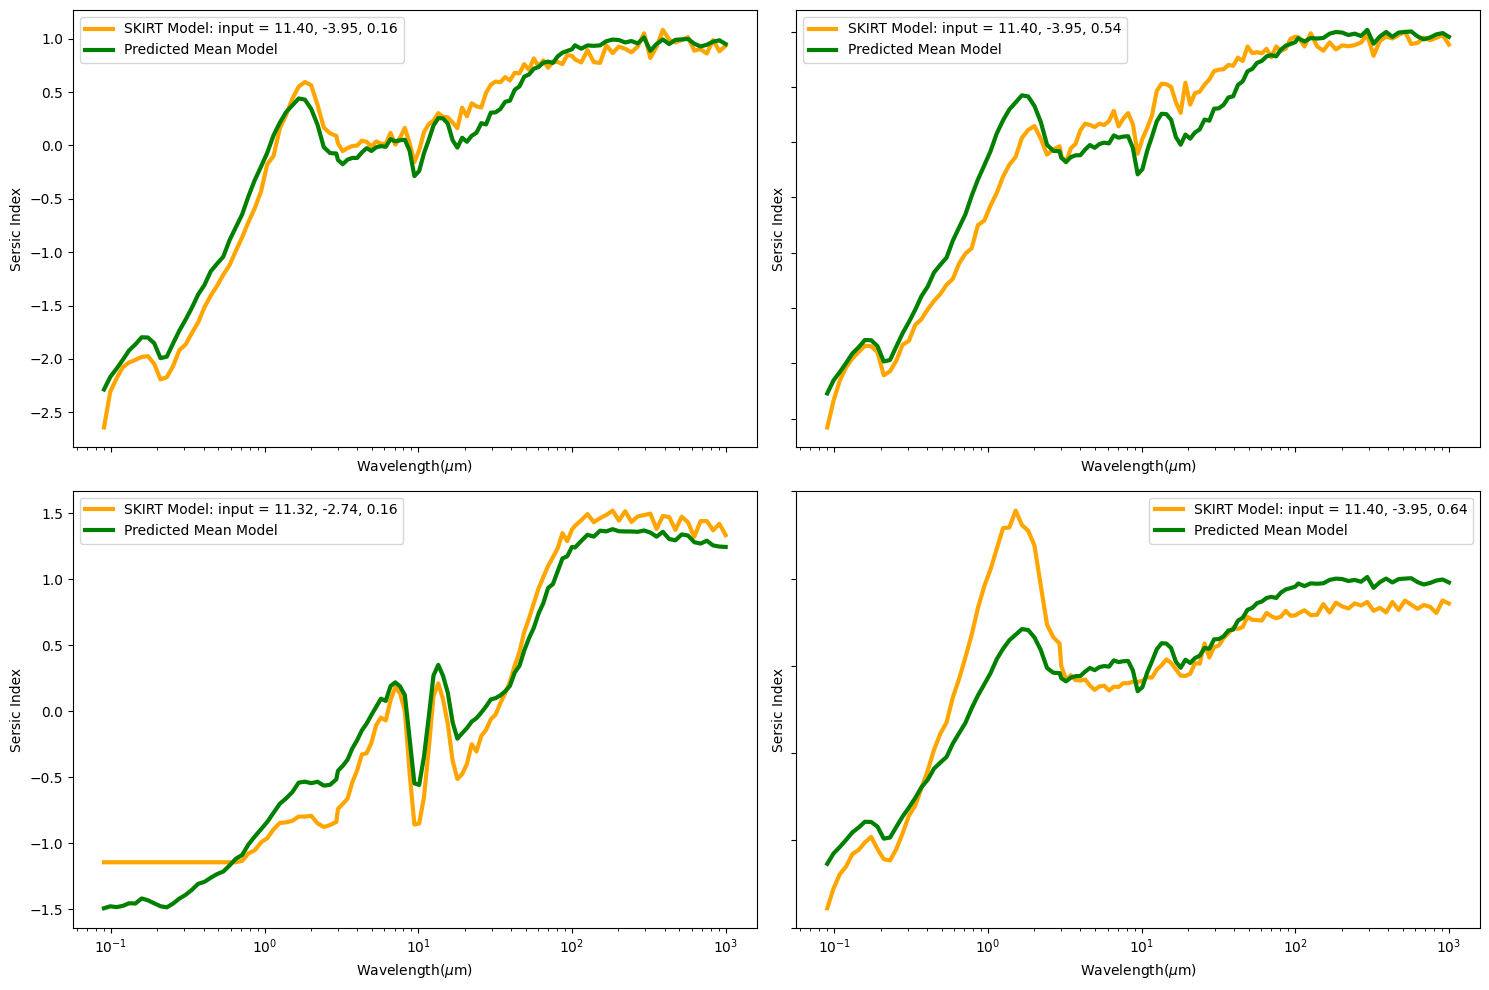

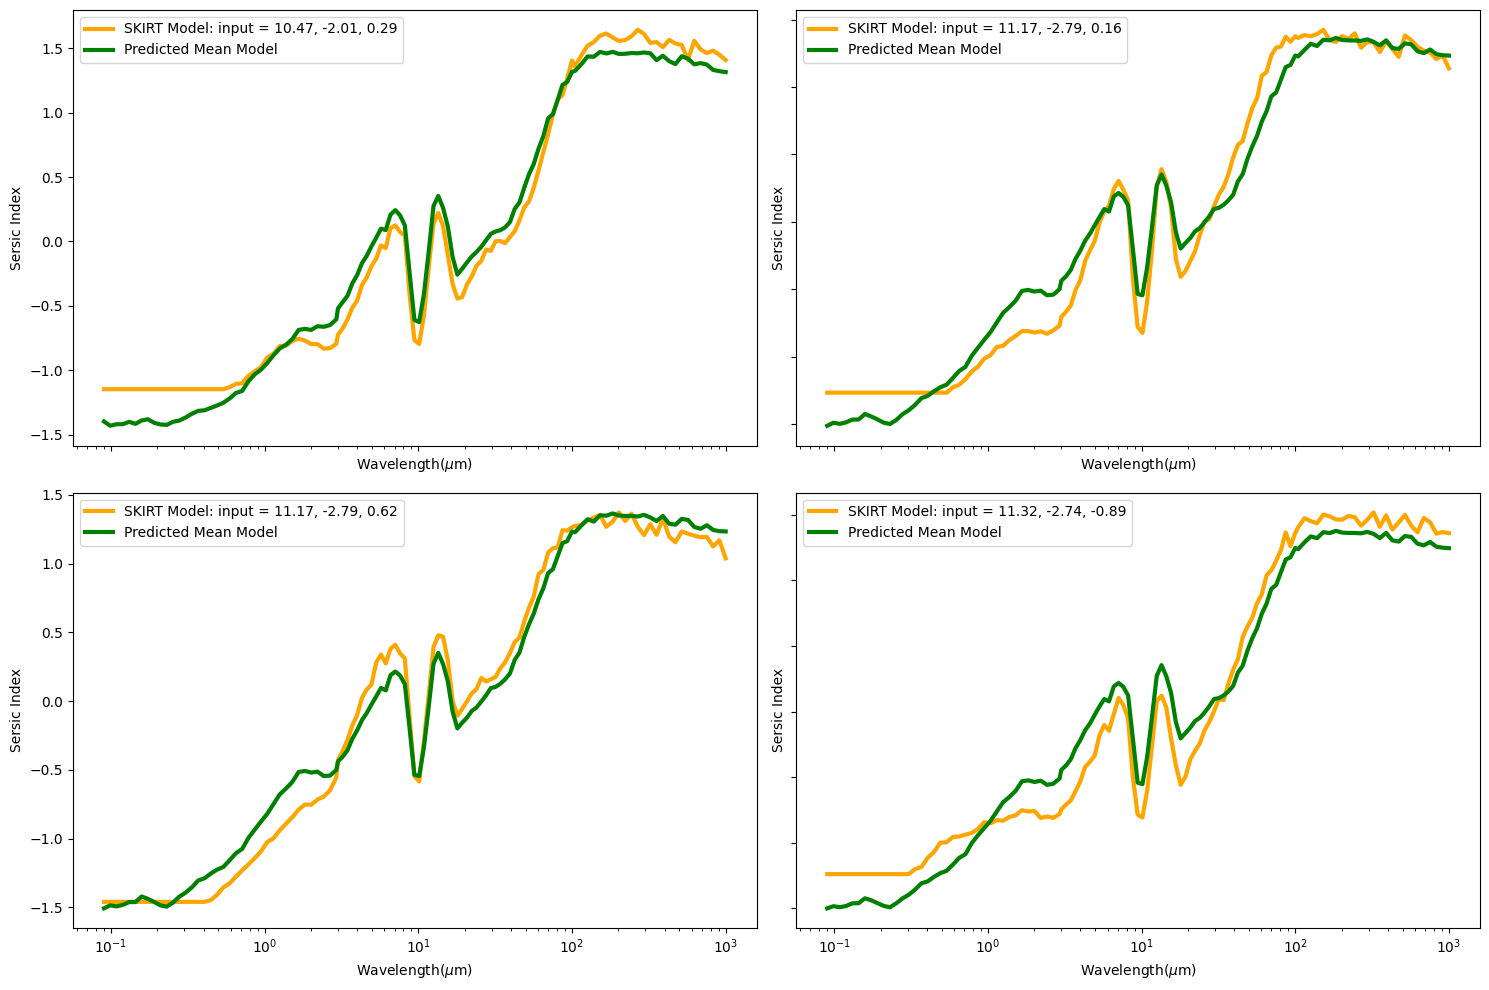

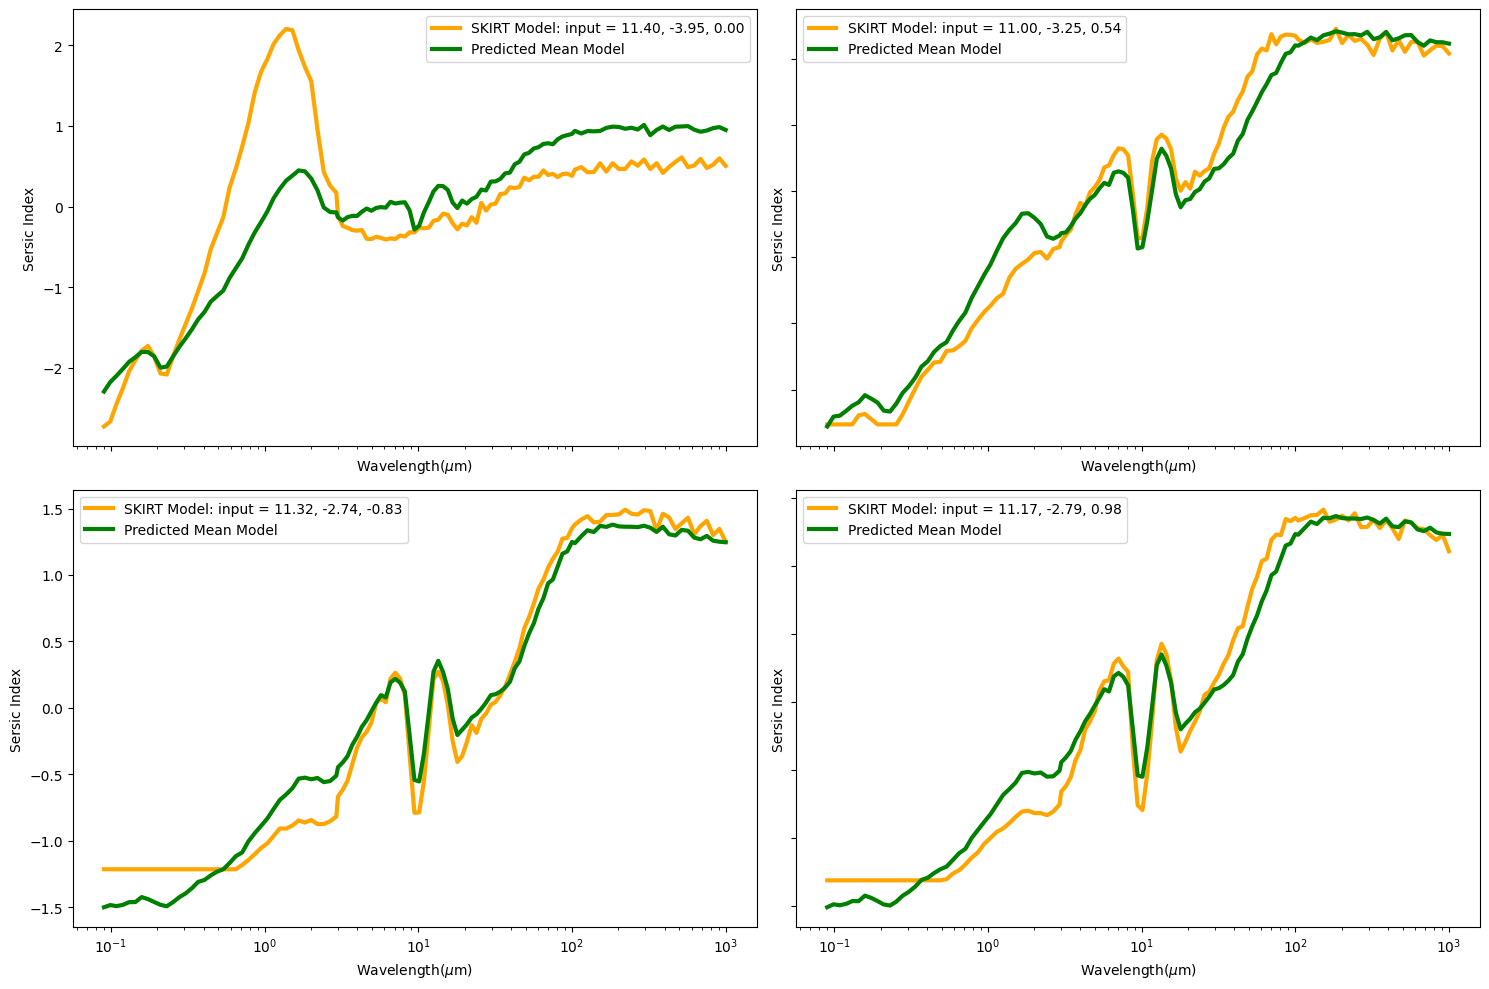

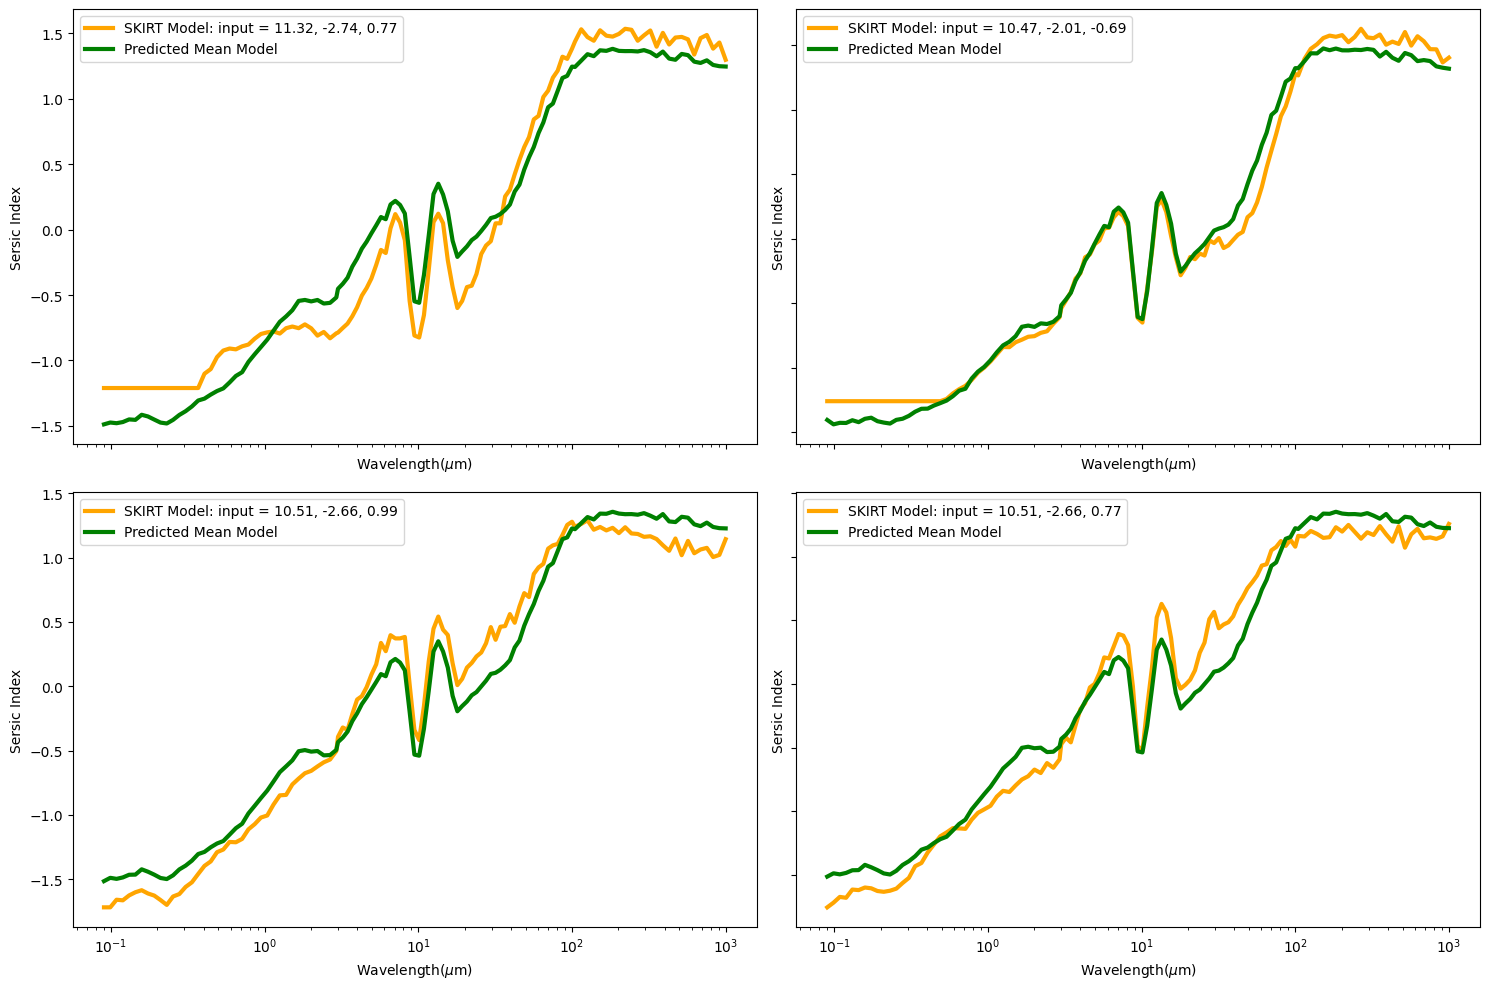

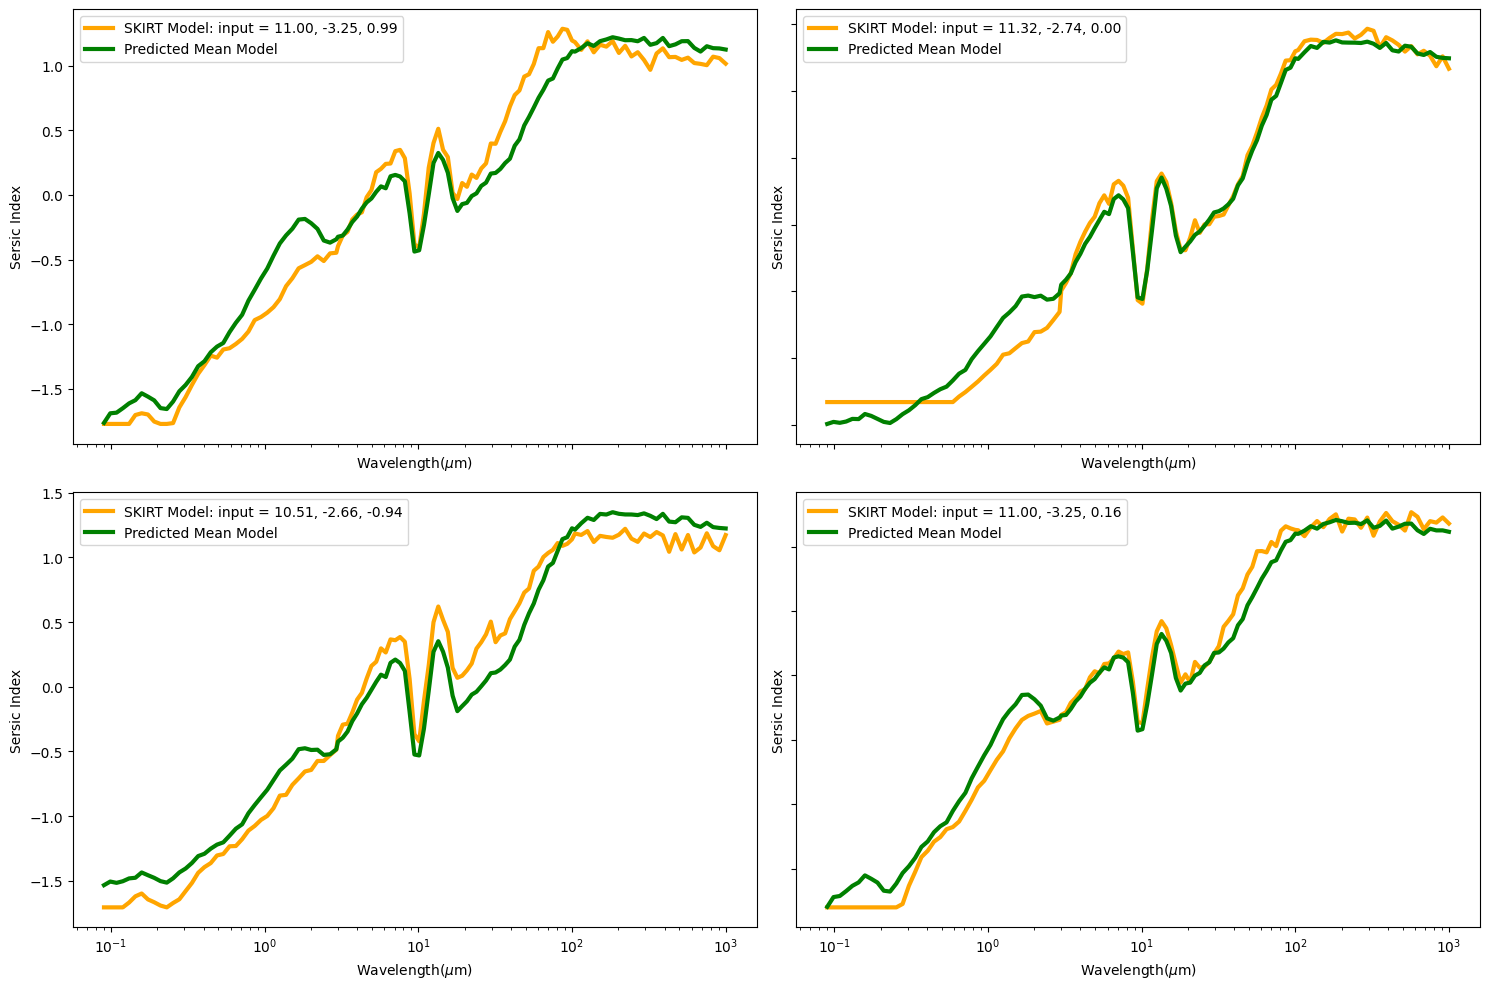

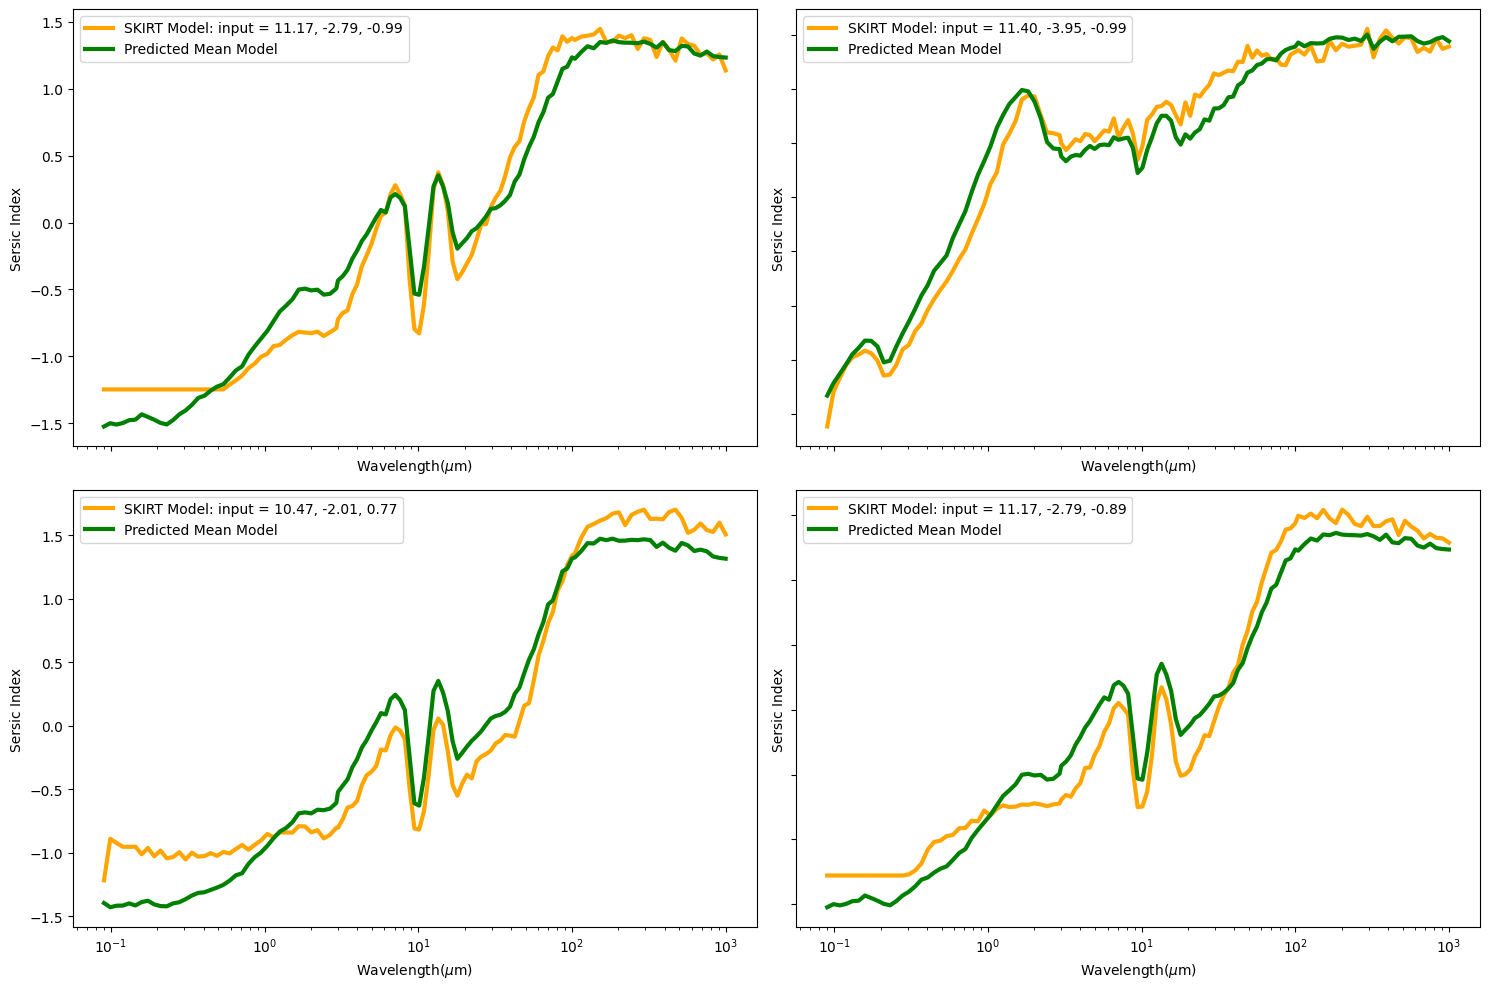

In [220]:
i = 0

while i <24:

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(wavelength,test_outputs[i,0,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i,0]:2.2f}, {test_inputs[i,1]:2.2f}, {test_inputs[i,2]:2.2f}')
    ax1.plot(wavelength,mean_n_results[:,i],color='green',lw=3,label='Predicted Mean Model')
    ax2.plot(wavelength,test_outputs[i+1,0,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+1,0]:2.2f}, {test_inputs[i+1,1]:2.2f}, {test_inputs[i+1,2]:2.2f}')
    ax2.plot(wavelength,mean_n_results[:,i+1],color='green',lw=3,label='Predicted Mean Model')
    ax3.plot(wavelength,test_outputs[i+2,0,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+2,0]:2.2f}, {test_inputs[i+2,1]:2.2f}, {test_inputs[i+2,2]:2.2f}')
    ax3.plot(wavelength,mean_n_results[:,i+2],color='green',lw=3,label='Predicted Mean Model')
    ax4.plot(wavelength,test_outputs[i+3,0,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+3,0]:2.2f}, {test_inputs[i+3,1]:2.2f}, {test_inputs[i+3,2]:2.2f}')
    ax4.plot(wavelength,mean_n_results[:,i+3],color='green',lw=3,label='Predicted Mean Model')
    


    for ax in fig.get_axes():
        ax.label_outer()
        ax.set(xlabel=f'Wavelength($\\mu$m)', ylabel='Sersic Index')
        ax.set_xscale('log')
        ax.legend()

    plt.tight_layout()

    ax.legend()
    plt.show()
    plt.close()
    
    
    i = i+4


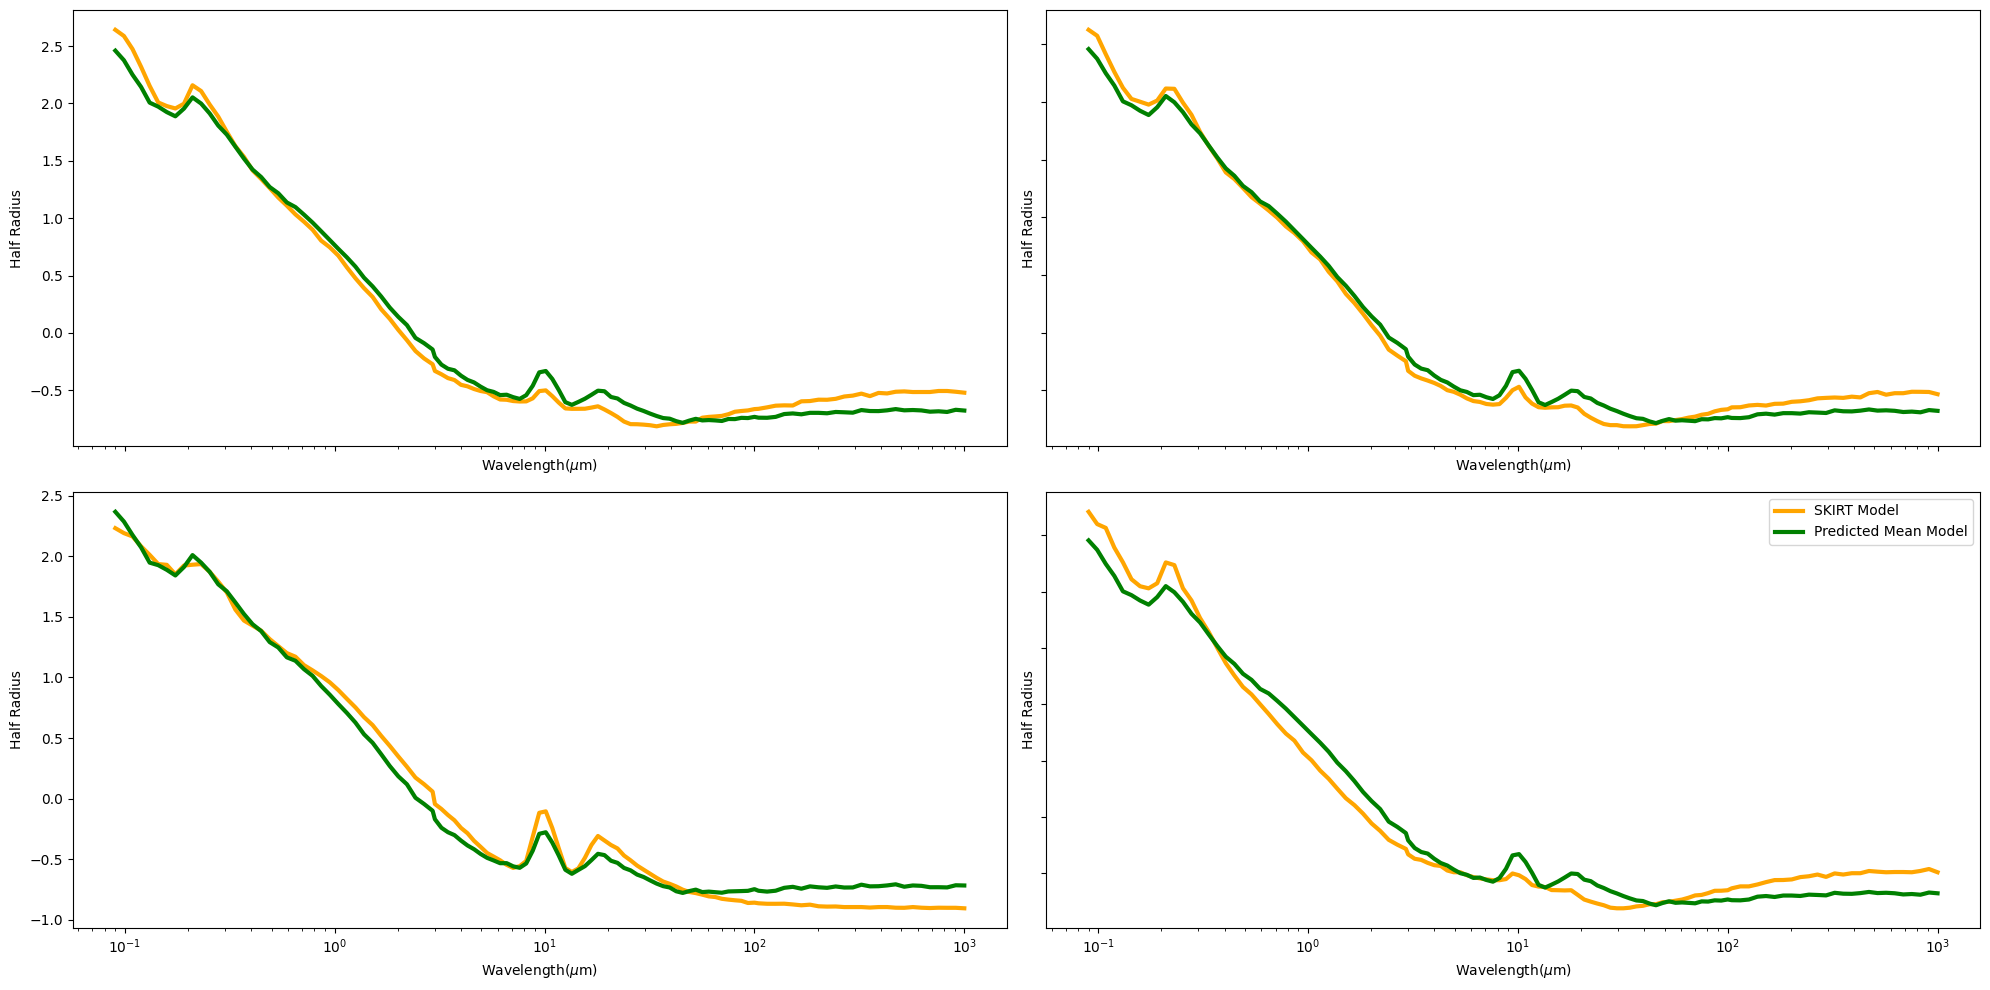

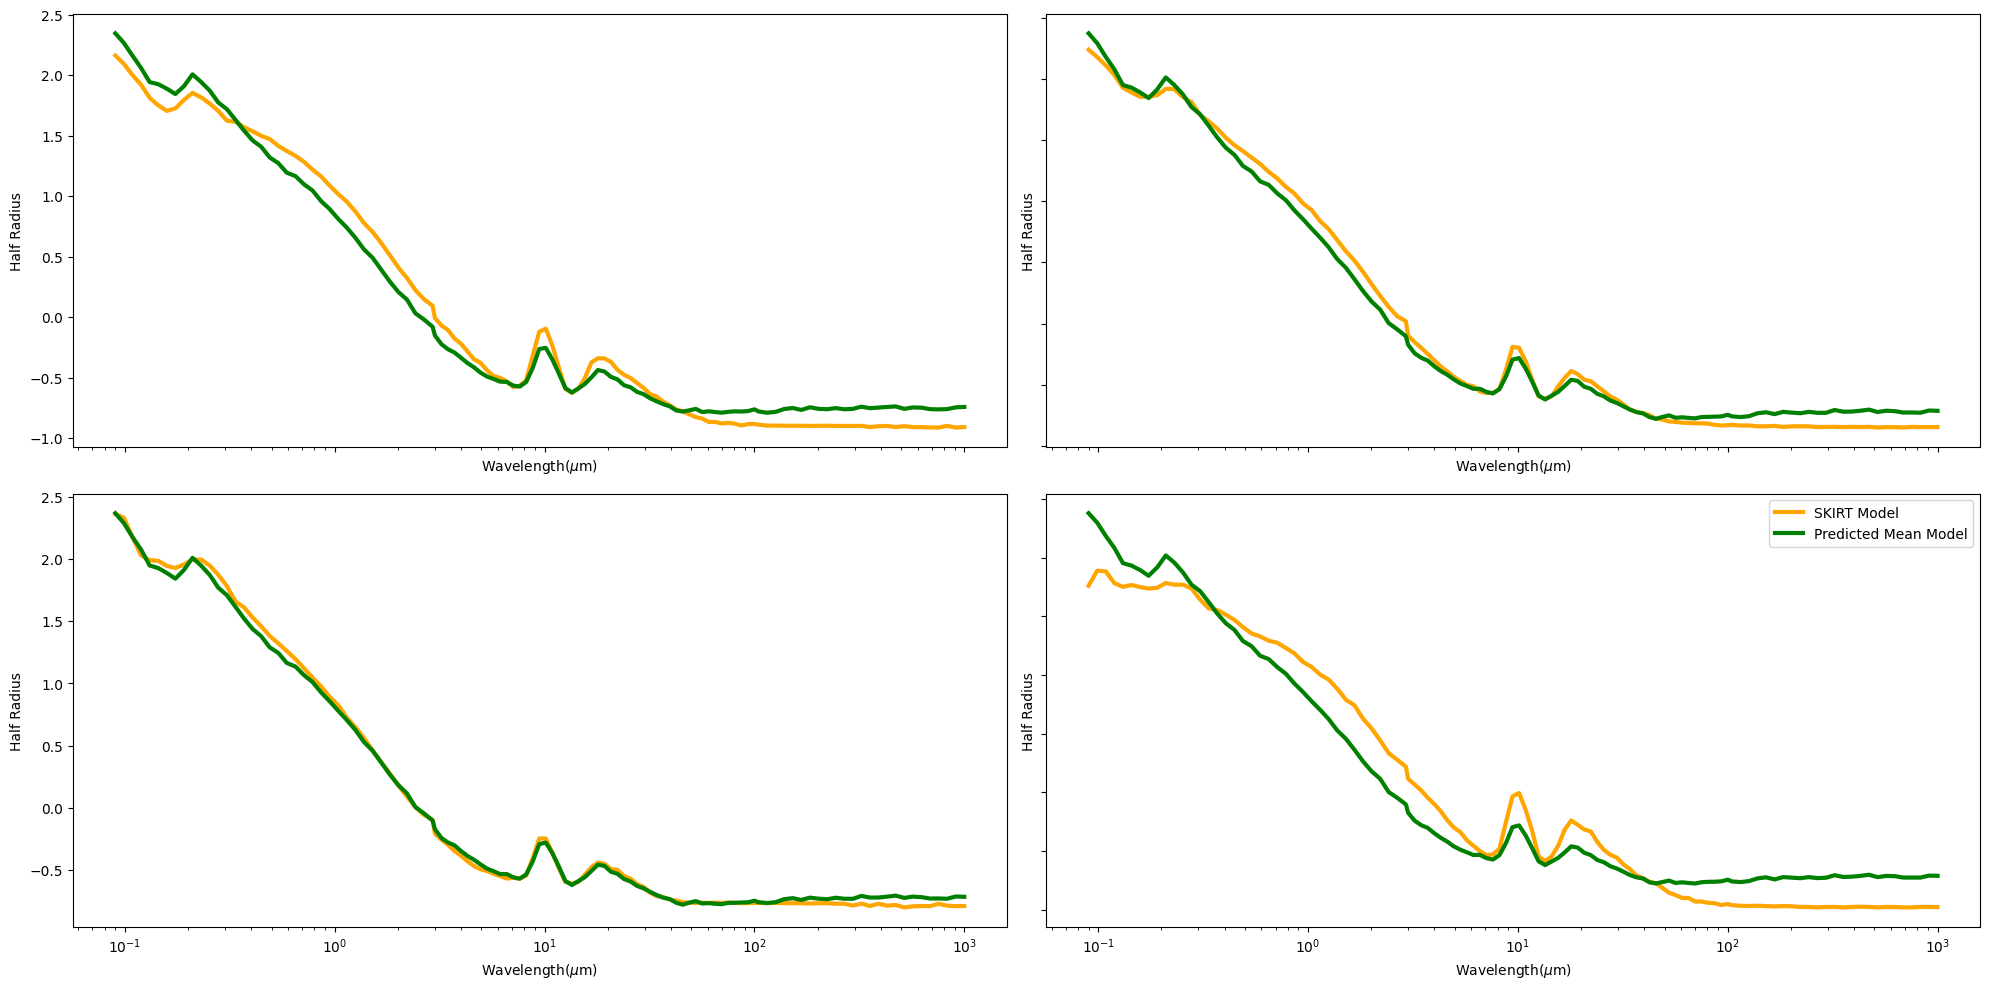

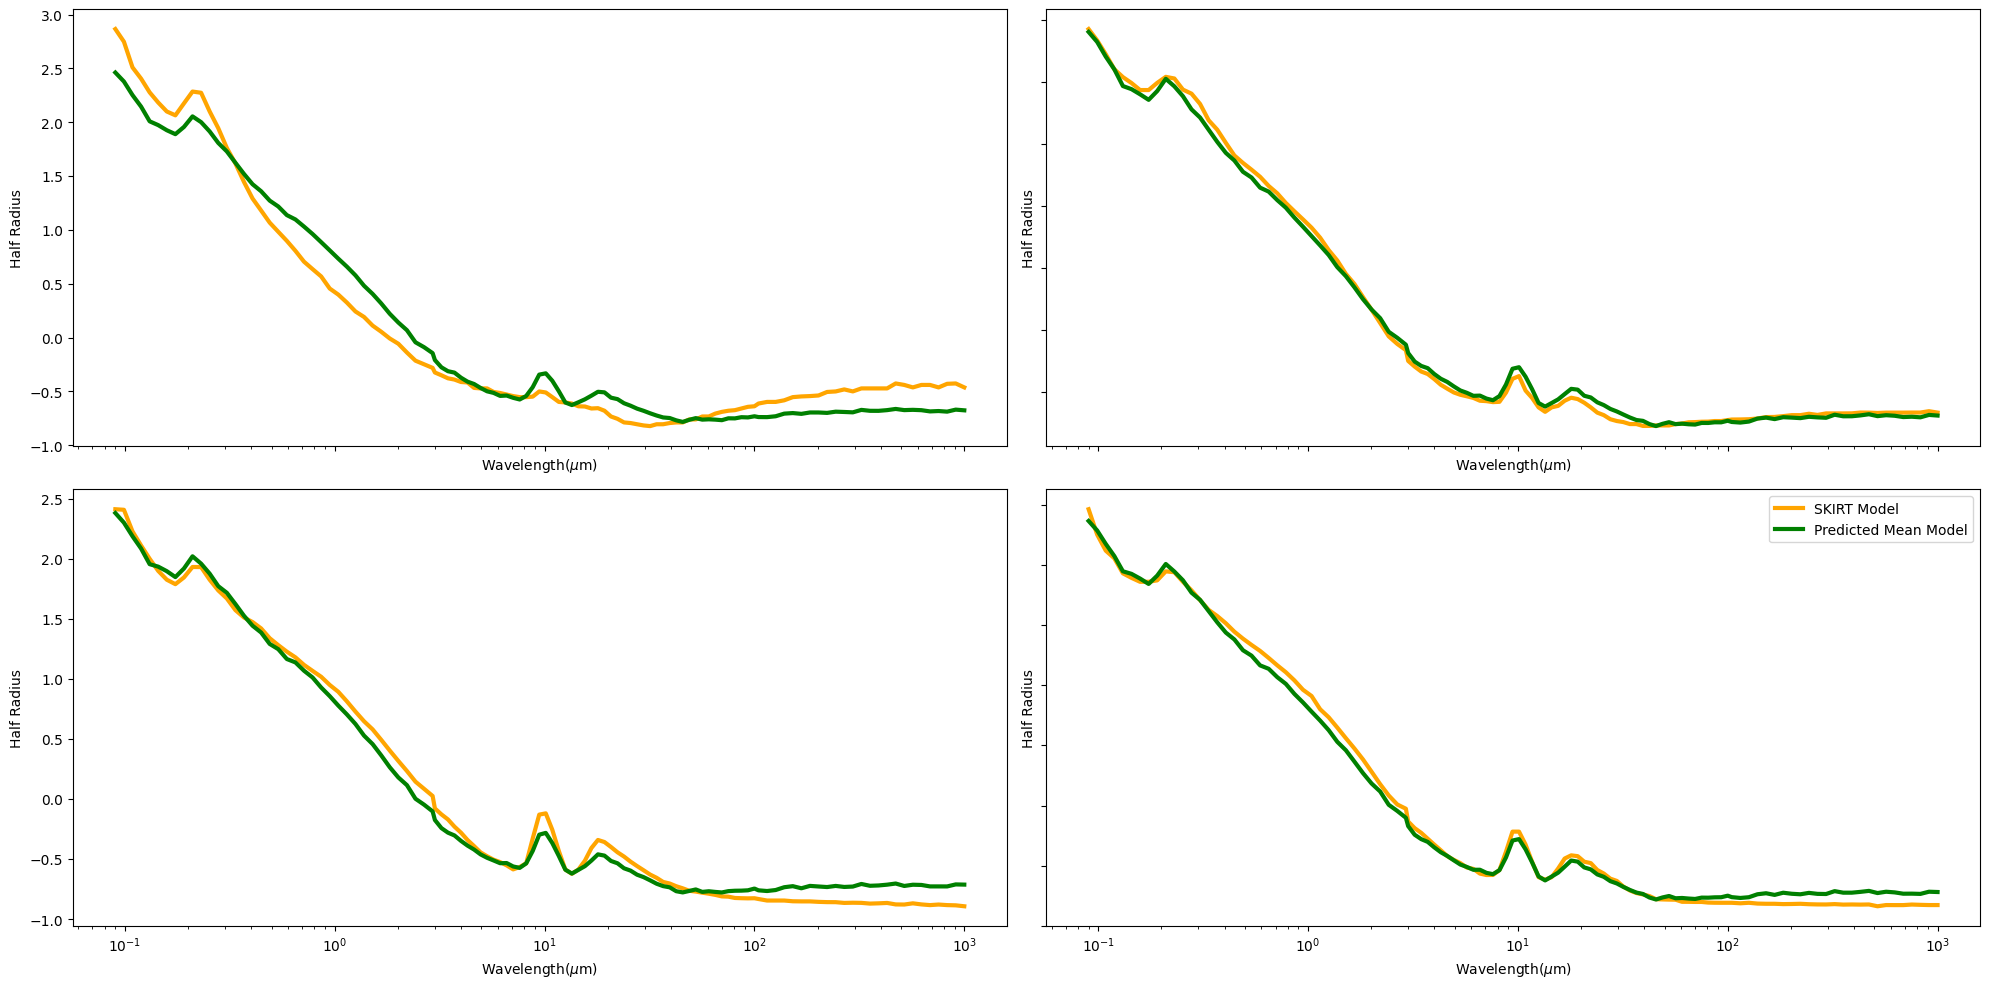

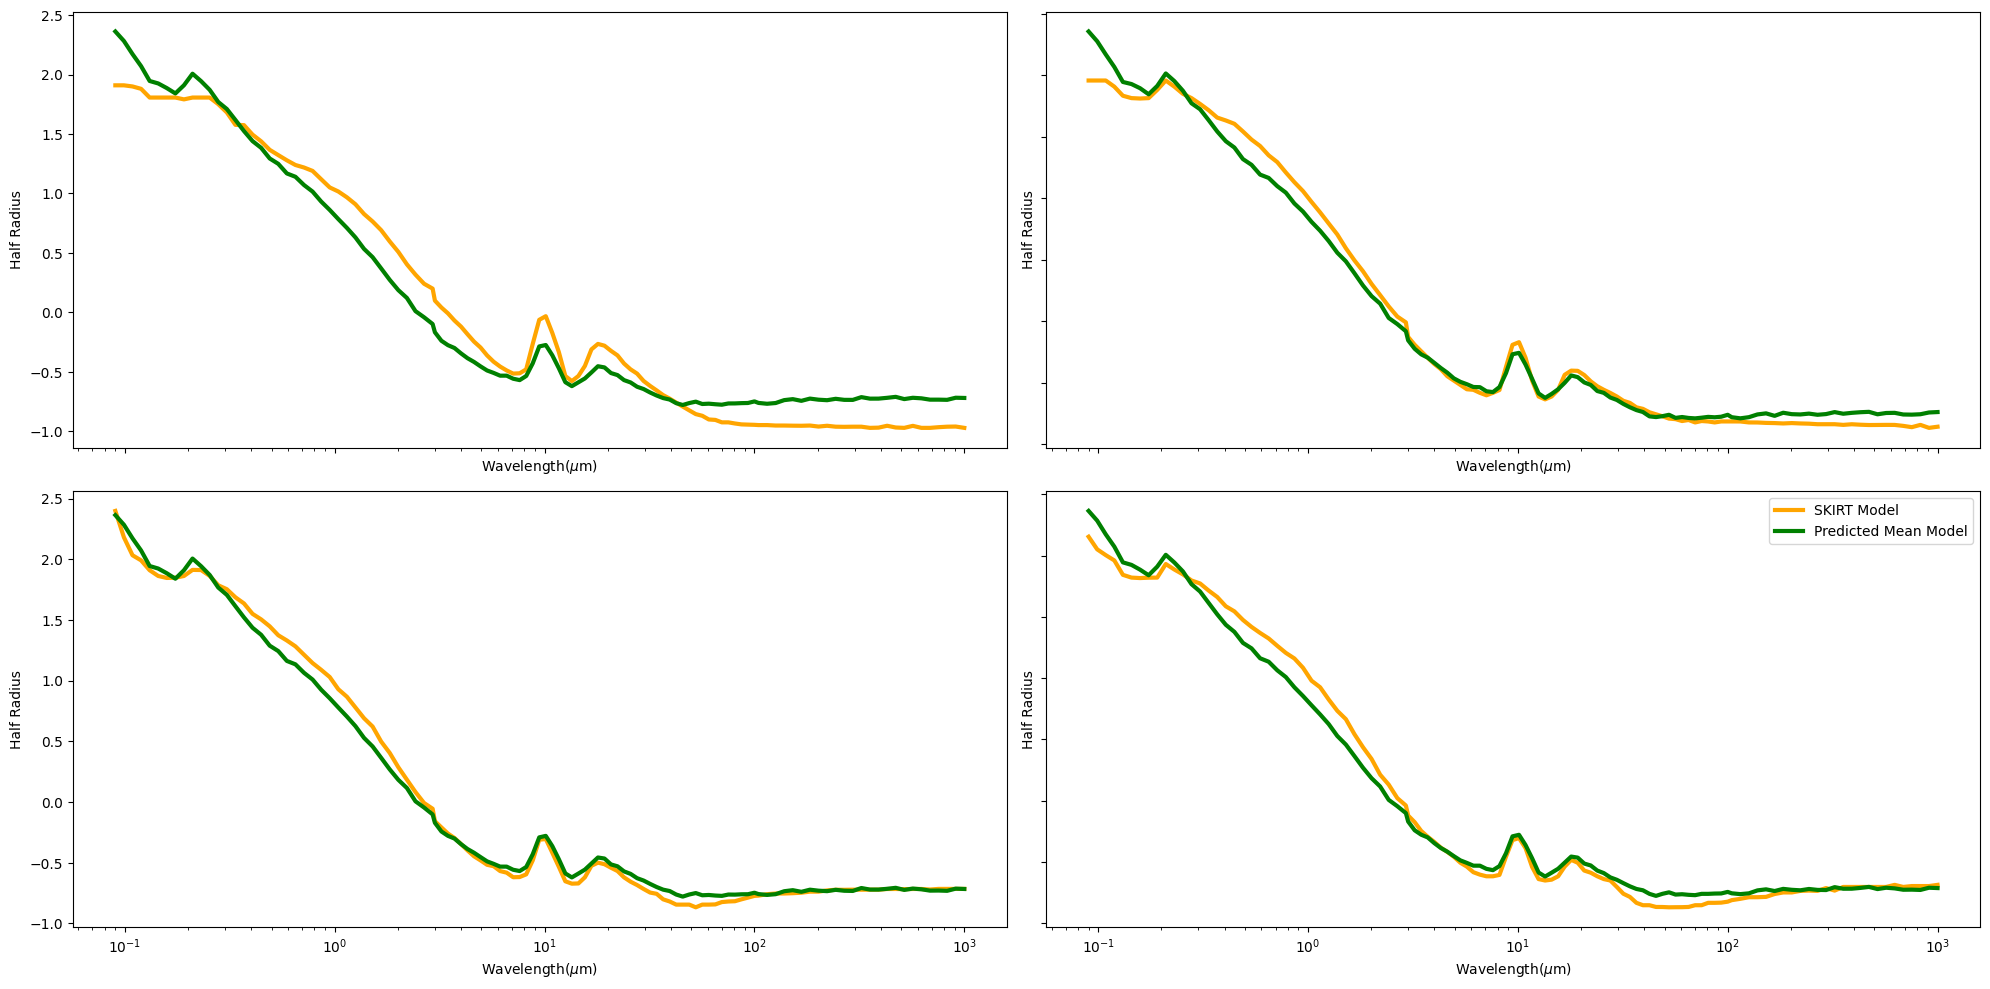

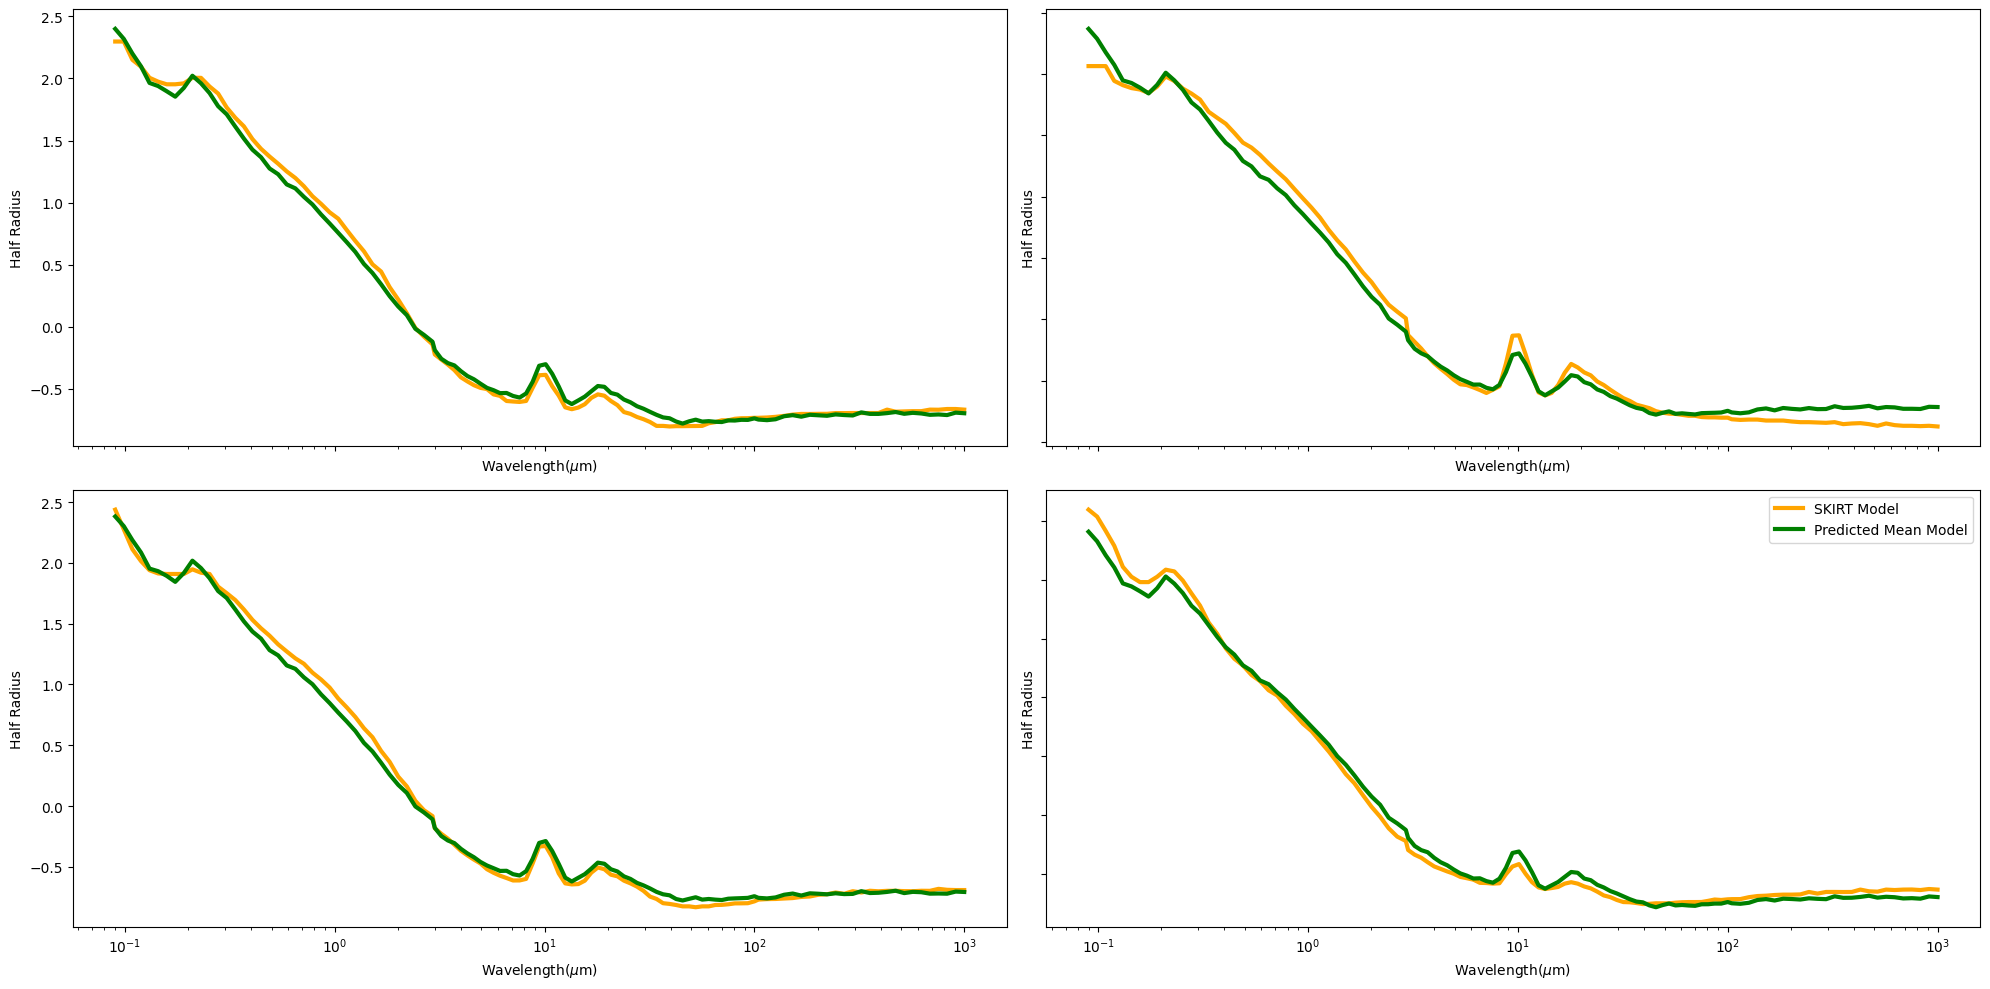

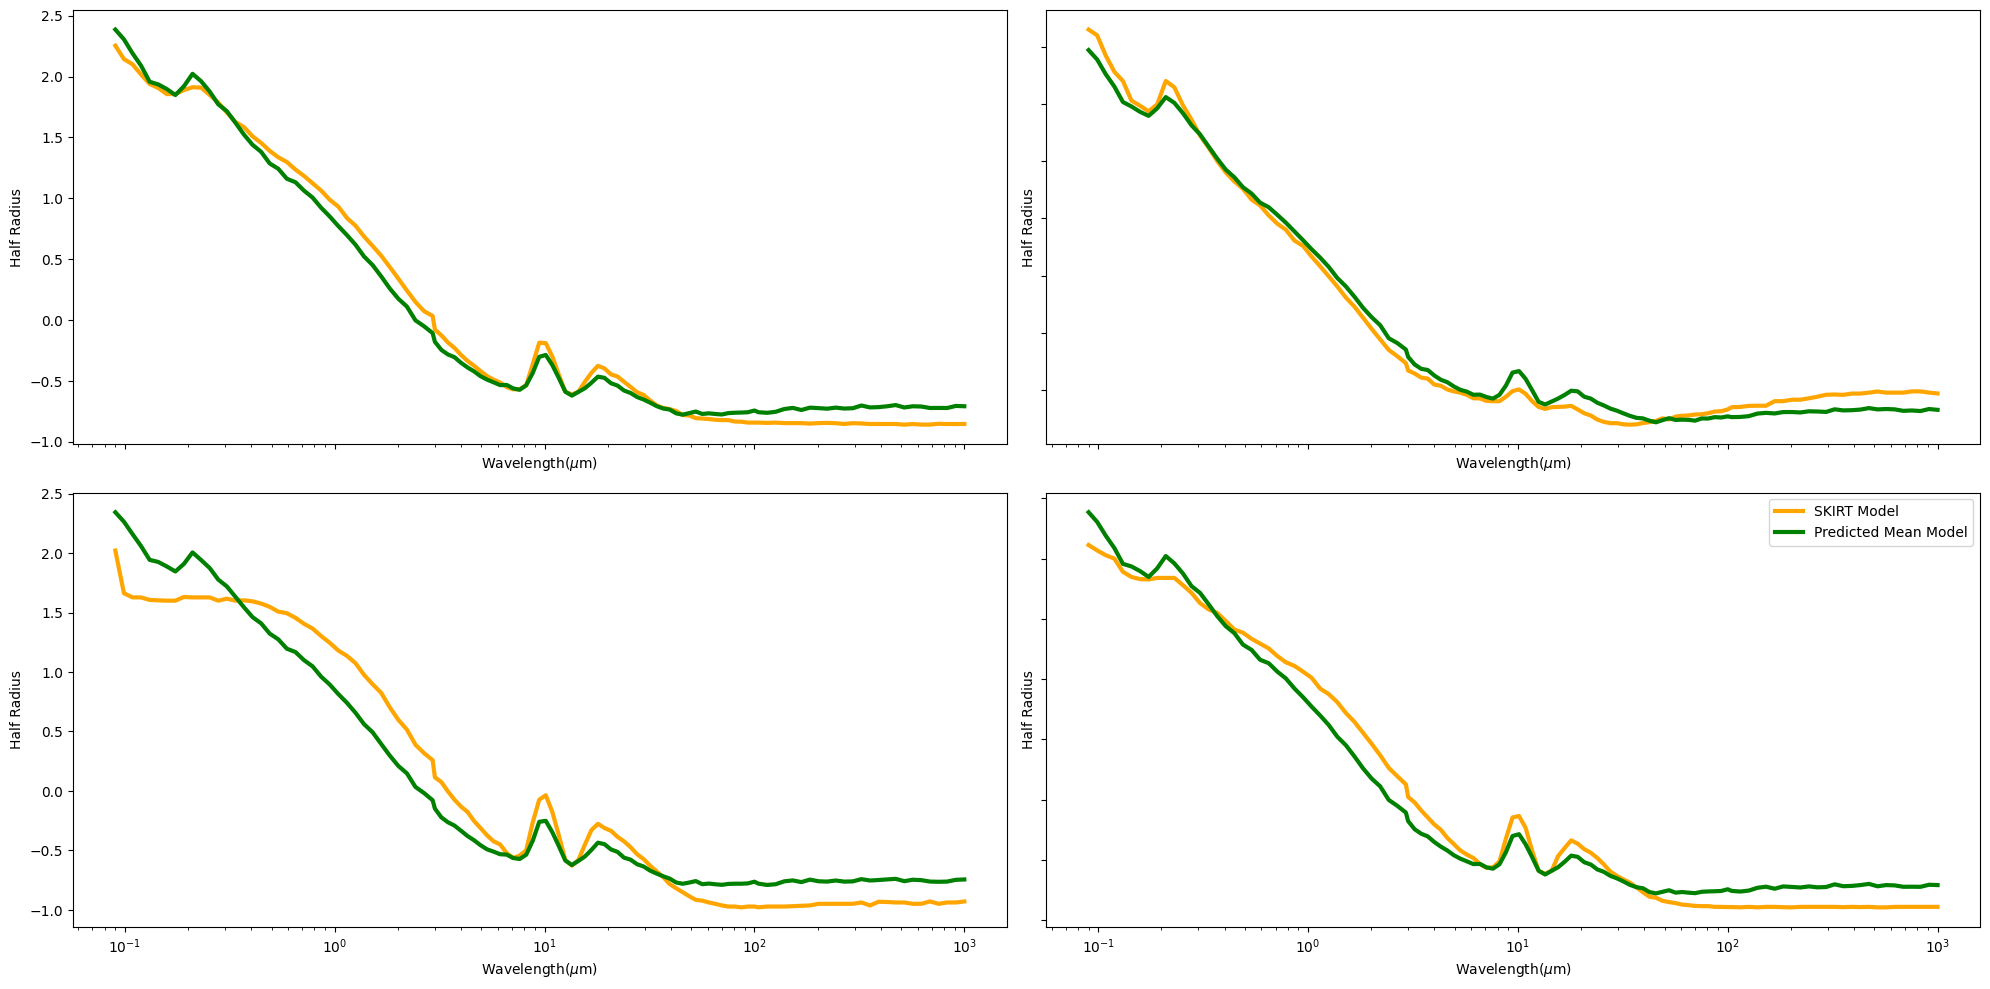

In [216]:
i = 0

while i <24:

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    ax1.plot(wavelength,test_outputs[i,2,:],color='orange',lw=3,label='SKIRT Model')
    ax1.plot(wavelength,mean_r_results[:,i],color='green',lw=3,label='Predicted Mean Model')
    ax2.plot(wavelength,test_outputs[i+1,2,:],color='orange',lw=3,label='SKIRT Model')
    ax2.plot(wavelength,mean_r_results[:,i+1],color='green',lw=3,label='Predicted Mean Model')
    ax3.plot(wavelength,test_outputs[i+2,2,:],color='orange',lw=3,label='SKIRT Model')
    ax3.plot(wavelength,mean_r_results[:,i+2],color='green',lw=3,label='Predicted Mean Model')
    ax4.plot(wavelength,test_outputs[i+3,2,:],color='orange',lw=3,label='SKIRT Model')
    ax4.plot(wavelength,mean_r_results[:,i+3],color='green',lw=3,label='Predicted Mean Model')
    


    for ax in fig.get_axes():
        ax.label_outer()
        ax.set(xlabel=f'Wavelength($\\mu$m)', ylabel='Half Radius')
        ax.set_xscale('log')
        ax.legend()

    plt.tight_layout()

    
    plt.show()
    plt.close()
    
    
    i = i+4


In [212]:
print(mean_n_results[:,0], test_inputs[0,:])


[-2.2859483  -2.1683183  -2.0910535  -2.0077603  -1.9200084  -1.8631917
 -1.7968396  -1.7992017  -1.8524989  -1.9923815  -1.9785733  -1.8546153
 -1.7348197  -1.6312646  -1.5200777  -1.3958232  -1.3068912  -1.1787626
 -1.1085325  -1.0417988  -0.88655394 -0.7655082  -0.64602447 -0.47662058
 -0.32605648 -0.19909543 -0.06861548  0.0949319   0.21351908  0.3129051
  0.37566844  0.44057116  0.42938045  0.34182686  0.19585912 -0.01508695
 -0.07098395 -0.07557652 -0.13643505 -0.17505899 -0.1325551  -0.11640384
 -0.11681173 -0.06507373 -0.02514644 -0.05157086 -0.01689874 -0.00601957
 -0.01261521  0.05921572  0.03856875  0.04899218  0.05344854 -0.04979189
 -0.28683484 -0.23913975 -0.07337021  0.05223142  0.18734     0.25611967
  0.2534642   0.20441884  0.04898179 -0.01995835  0.07240231  0.03483055
  0.09109306  0.11918356  0.20862015  0.1973836   0.3073529   0.31022123
  0.3414028   0.4092151   0.41903558  0.52138674  0.5534353   0.6444192
  0.6648363   0.71882725  0.73543084  0.7758154   0.7852

In [215]:
print(mean_n_results[:,7], test_inputs[7,:])


[-1.5019412  -1.485695   -1.4935143  -1.484336   -1.463607   -1.4629931
 -1.4253101  -1.4405826  -1.4621825  -1.48374    -1.4940907  -1.4633317
 -1.4258862  -1.3974435  -1.358459   -1.310687   -1.2963144  -1.2618787
 -1.2336912  -1.2154716  -1.1690123  -1.116896   -1.0893164  -1.0053196
 -0.94410914 -0.8898014  -0.83401793 -0.7627838  -0.6930411  -0.6521599
 -0.605562   -0.53279555 -0.52537006 -0.53776824 -0.52792645 -0.55934745
 -0.5512698  -0.5110434  -0.4467796  -0.41127825 -0.36406922 -0.27869728
 -0.21779786 -0.14301667 -0.09248734 -0.02571604  0.03836026  0.09514289
  0.07768359  0.19135614  0.21803501  0.18867484  0.12262839 -0.20732398
 -0.54313326 -0.55383915 -0.34365115 -0.04241567  0.2719019   0.35392892
  0.2690693   0.14141871 -0.08029237 -0.20473738 -0.16462895 -0.12383248
 -0.07294949 -0.04847342 -0.0076912   0.03995887  0.09536808  0.10233863
  0.12202398  0.15300089  0.19579081  0.2978736   0.349888    0.46509266
  0.5591844   0.635534    0.7467666   0.82366765  0.9372